In [1]:
from typing import *
from pathlib import Path
from tqdm import tqdm


import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings("ignore")


ROOT_DIR = Path(os.getcwd()).parent.parent

In [2]:
df: pd.DataFrame = pd.read_parquet(
    os.path.join(ROOT_DIR, "data/datasets/train_14_06_2.parquet")
)

df = df.reset_index(drop=True)
# Create pump hash and convert pump time to datetime
df["pump_hash"] = df["pumped_ticker"] + "_" + df["pump_time"]
df["pump_time"] = pd.to_datetime(df["pump_time"])

df.head(1)

,overall_return_1h,volume_qty_abs_zscore_1h_30d,volume_quote_abs_zscore_1h_30d,num_trades_long_share_1h,volume_quote_long_share_1h,overall_return_3h,volume_qty_abs_zscore_3h_30d,volume_quote_abs_zscore_3h_30d,num_trades_long_share_3h,volume_quote_long_share_3h,...,quote_abs_powerlaw_alpha_72h,quote_abs_kurt_72h_30d,num_prev_pumps,exchange,pumped_ticker,pump_time,ticker,is_pumped,days_listed,pump_hash
0,1.015587,0.580751,1.259192,0.520089,0.623967,1.039085,0.050684,0.674123,0.542722,0.573275,...,0.257903,0.386353,0,binance,PPTBTC,2018-01-03 18:00:00,MTHBTC,False,82,PPTBTC_2018-01-03 18:00:00


In [3]:
df = df.replace([np.inf, -np.inf], np.nan)

df.isna().sum().sort_values()

overall_return_1h                        0
log_return_std_336h_30d                  0
log_return_skew_336h                     0
volume_quote_long_share_336h             0
num_trades_long_share_336h               0
                                      ... 
quote_slippage_imbalance_ratio_12h     281
quote_abs_kurt_1h_30d                  485
quote_slippage_imbalance_ratio_6h      620
quote_slippage_imbalance_ratio_3h     1304
quote_slippage_imbalance_ratio_1h     4025
Length: 141, dtype: int64

In [4]:
df = df.drop(
    columns=["quote_slippage_abs_share_72h_72h", "quote_slippage_abs_long_share_72h_72h"]
)

In [5]:
num_cols: List[str] = df.columns[:-8].tolist() + ["days_listed"]
cat_cols: List[str] = ["num_prev_pumps"]

reg_cols: List[str] = num_cols + cat_cols

In [6]:
df[cat_cols] = df[cat_cols].astype("category")

<h4>Fill nans with median value, if it is not pumped observation</h4>

In [7]:
# skip pump if any variable is missing
df_pumps = pd.DataFrame()

for i, (pump_hash, df_pump) in enumerate(df.groupby("pump_hash")):
    # if any feature is missing for the pump observation, then there is no point to fill it with median value
    if any(df_pump[df_pump["is_pumped"]].isna().any()):
        continue
    # otherwise fill other cols with median
    for col in num_cols:
        col_median: float = df_pump[col].median()
        df_pump[col] = df_pump[col].fillna(col_median)

    df_pump["pump_id"] = i

    df_pumps = pd.concat([df_pumps, df_pump])

In [8]:
df_pumps["is_pumped"].value_counts()

is_pumped
False    37831
True       337
Name: count, dtype: int64

<h4>Cross-section statistics</h4>

In [9]:
pumps_plot: np.array = np.random.choice(df_pumps["pump_hash"].unique(), 5, replace=False)
df_plot: pd.DataFrame = df_pumps[df_pumps["pump_hash"].isin(pumps_plot)].copy()

 80%|████████  | 12/15 [00:01<00:00,  8.49it/s]


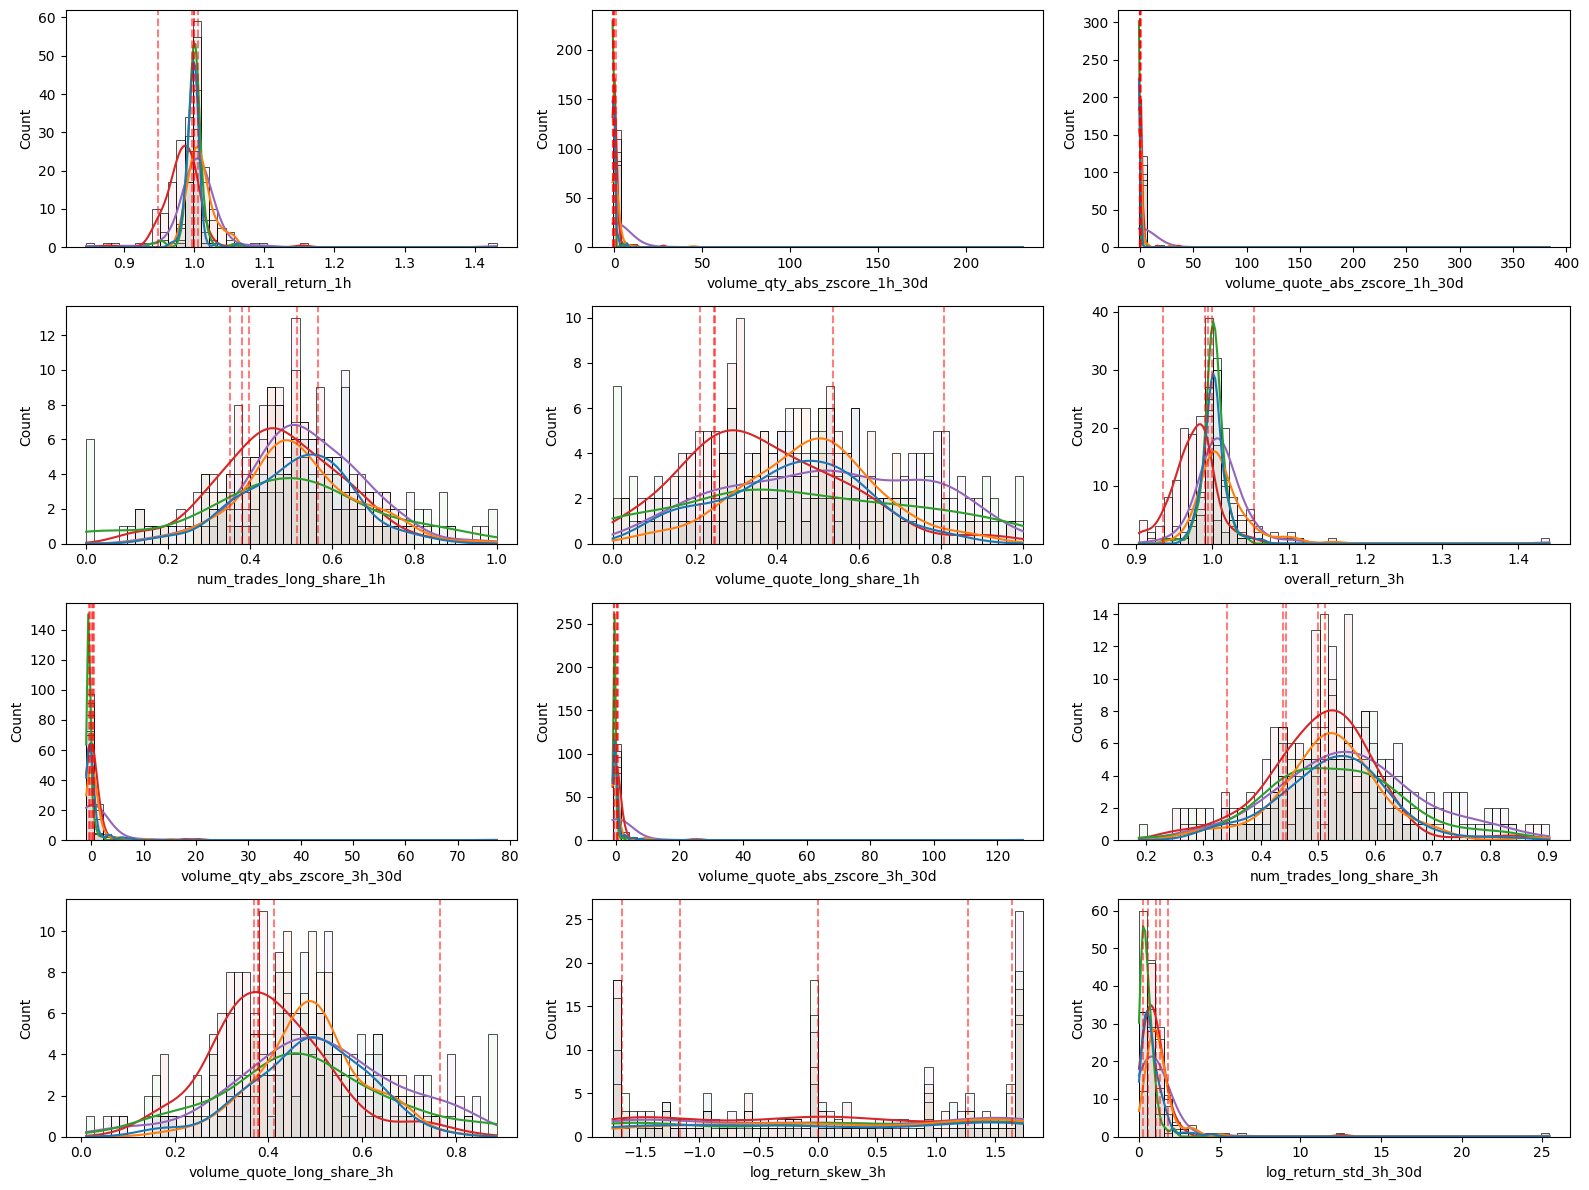

In [10]:
fig, axs = plt.subplots(4, 3, figsize=(16, 12))
axs = [el for ax in axs for el in ax]

for col, ax in tqdm(zip(reg_cols[:12], axs), total=15):
    sns.histplot(
        data=df_plot, x=col, hue="pump_hash", ax=ax, legend=False, bins=50, alpha=.05, kde=True
    )

    for pump_hash in pumps_plot:
        pumped_ticker: pd.Series = (
            (df_plot["pump_hash"] == pump_hash) & (df_plot["is_pumped"])
        )
        ax.axvline(
            x=df_plot[pumped_ticker][col].iloc[-1], color="red", linestyle="--", alpha=.5
        )

plt.tight_layout()
plt.savefig("features_without_norm.png", transparent=True)
plt.show()

<h4>Crosssectional standartisation</h4>

In [11]:
df_scaled: pd.DataFrame = pd.DataFrame()

for pump_hash, df_pump in tqdm(df_pumps.groupby("pump_hash")):
    # Scale each pump by its crosssection
    for col in num_cols:
        df_pump[col] = (df_pump[col] - df_pump[col].mean()) / df_pump[col].std()

    df_scaled = pd.concat([df_scaled, df_pump])

df_scaled.head(2)

100%|██████████| 337/337 [00:07<00:00, 47.68it/s]


,overall_return_1h,volume_qty_abs_zscore_1h_30d,volume_quote_abs_zscore_1h_30d,num_trades_long_share_1h,volume_quote_long_share_1h,overall_return_3h,volume_qty_abs_zscore_3h_30d,volume_quote_abs_zscore_3h_30d,num_trades_long_share_3h,volume_quote_long_share_3h,...,quote_abs_kurt_72h_30d,num_prev_pumps,exchange,pumped_ticker,pump_time,ticker,is_pumped,days_listed,pump_hash,pump_id
10859,-0.011500,-0.238060,-0.213028,0.053803,-1.398087,0.128068,-0.011452,-0.021406,0.157610,1.015828,...,1.623295,1,binance,ADXBTC,2019-07-05 17:00:00,POWRBTC,False,0.671990,ADXBTC_2019-07-05 17:00:00,0
10860,-0.444179,-0.447109,-0.370362,0.220069,-1.132008,0.437916,-0.614615,-0.516197,-0.809509,-0.795369,...,0.961010,0,binance,ADXBTC,2019-07-05 17:00:00,DLTBTC,False,0.615211,ADXBTC_2019-07-05 17:00:00,0


100%|██████████| 12/12 [00:01<00:00,  9.28it/s]


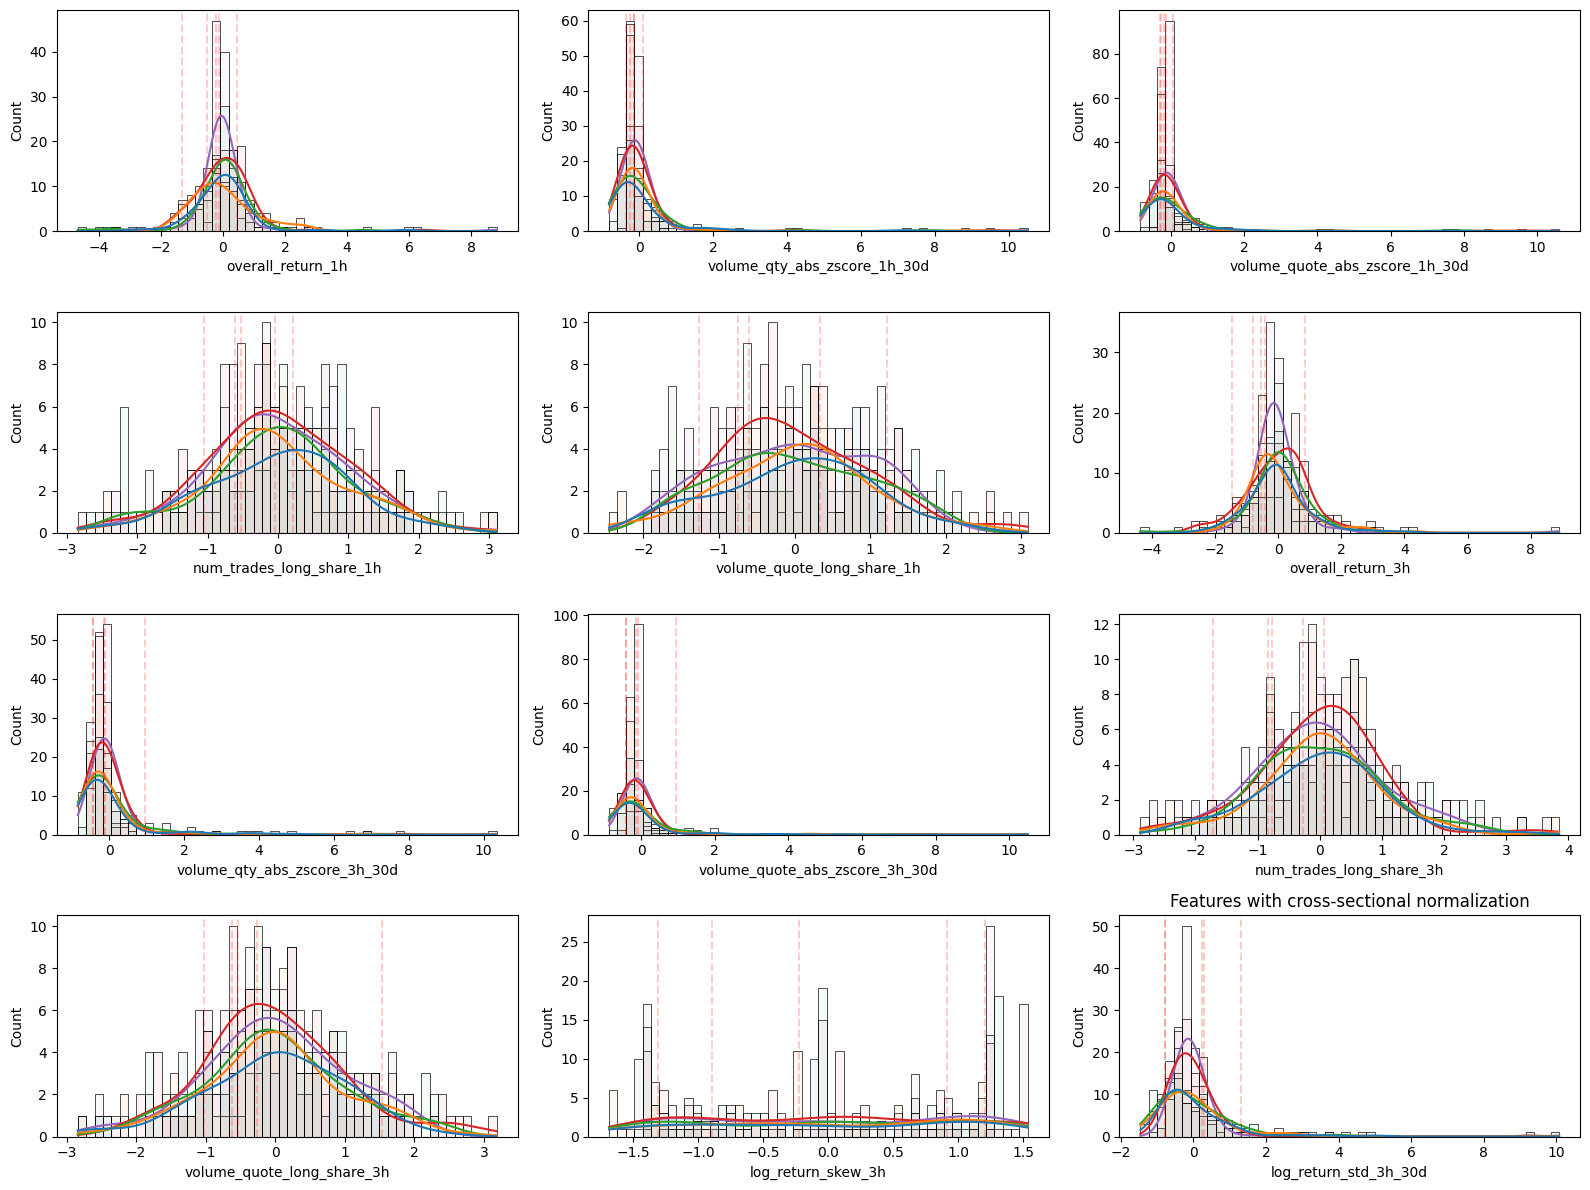

In [12]:
# plot scaled distributions
df_plot_scaled = df_scaled[df_scaled["pump_hash"].isin(pumps_plot)].copy()

fig, axs = plt.subplots(4, 3, figsize=(16, 12))
axs = [el for ax in axs for el in ax]

for col, ax in tqdm(zip(reg_cols[:12], axs), total=12):
    sns.histplot(
        data=df_plot_scaled, x=col, hue="pump_hash", ax=ax, legend=False, alpha=.05, bins=50, kde=True
    )

    for pump_hash in pumps_plot:
        pumped_ticker: pd.Series = (
            (df_plot_scaled["pump_hash"] == pump_hash) & (df_plot_scaled["is_pumped"])
        )
        ax.axvline(
            x=df_plot_scaled[pumped_ticker][col].iloc[-1], color="red", linestyle="--", alpha=.2
        )

plt.title("Features with cross-sectional normalization")
plt.tight_layout()
plt.savefig("features_with_norm.png", transparent=True)
plt.show()

<h4>Plot Cross-Norm and no Cross-Norm side by side</h4>

100%|██████████| 3/3 [00:00<00:00,  4.58it/s]


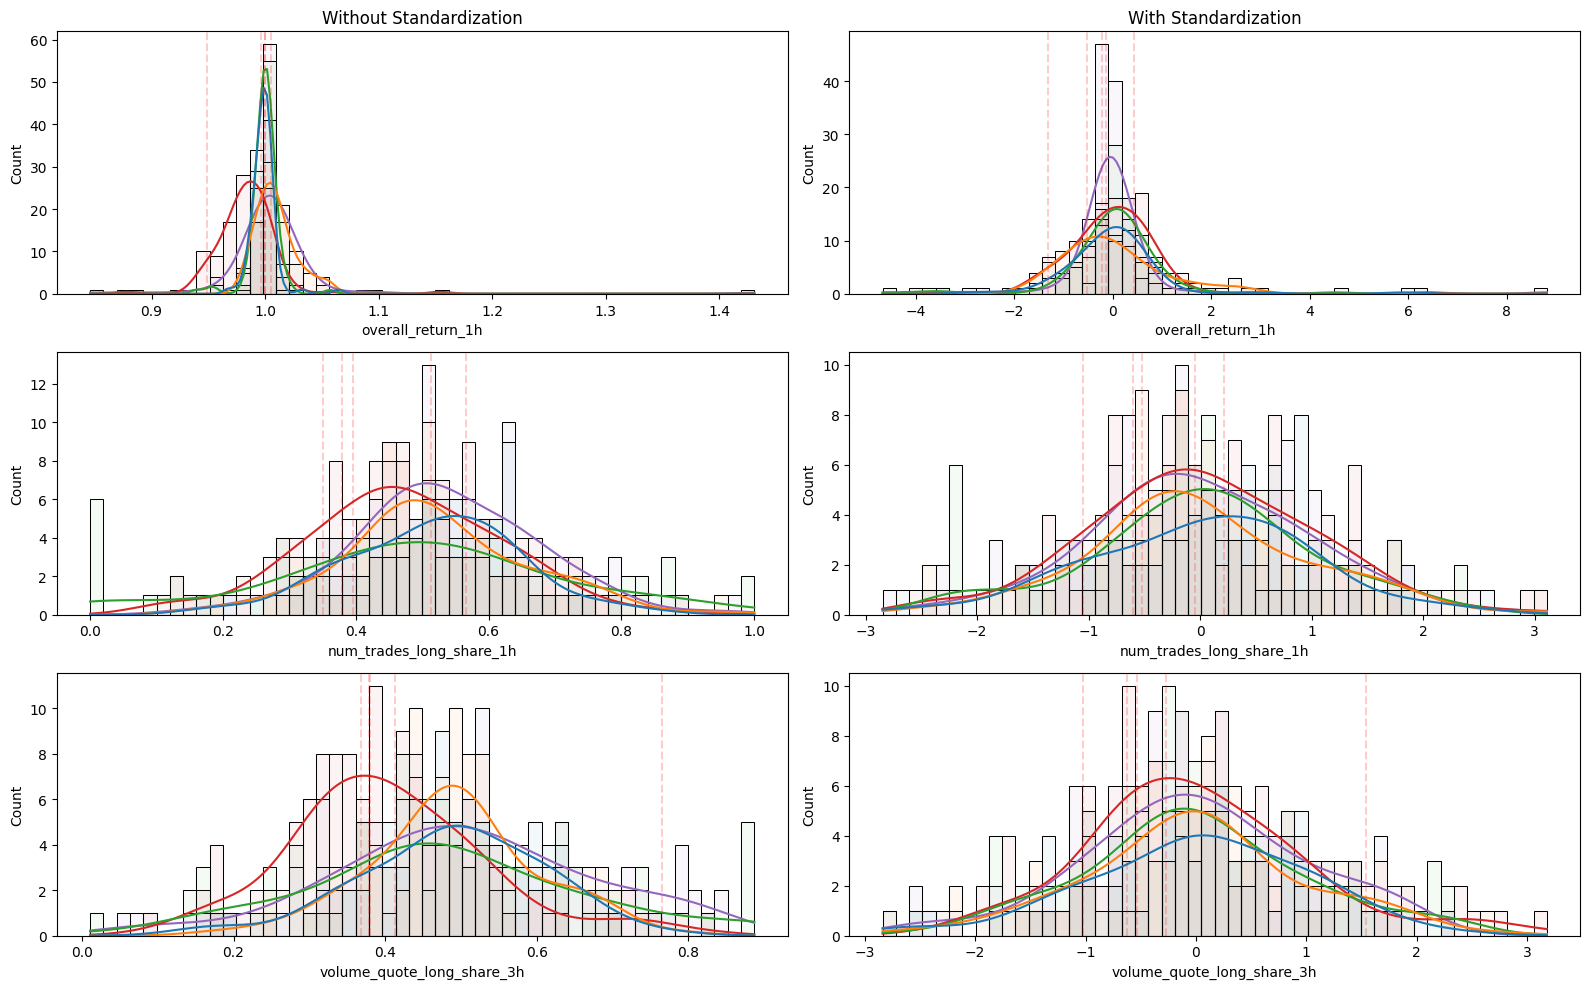

In [13]:
cols_to_plot: List[str] = [
    "overall_return_1h", "num_trades_long_share_1h", "volume_quote_long_share_3h"
]


fig, axs = plt.subplots(3, 2, figsize=(16, 10))

for col, (ax1, ax2) in tqdm(zip(cols_to_plot, axs), total=3):

    # Plot not scaled and scaled hists
    sns.histplot(data=df_plot, x=col, hue="pump_hash", ax=ax1, legend=False, alpha=.05, bins=50, kde=True)
    sns.histplot(data=df_plot_scaled, x=col, hue="pump_hash", ax=ax2, legend=False, alpha=.05, bins=50, kde=True)

    for pump_hash in pumps_plot:
        pumped_ticker: pd.Series = (
            (df_plot["pump_hash"] == pump_hash) & (df_plot["is_pumped"])
        )
        pumped_ticker_scaled: pd.Series = (
            (df_plot_scaled["pump_hash"] == pump_hash) & (df_plot_scaled["is_pumped"])
        )

        ax1.axvline(x=df_plot[pumped_ticker][col].iloc[-1], color="red", linestyle="--", alpha=.2)
        ax2.axvline(x=df_plot_scaled[pumped_ticker_scaled][col].iloc[-1], color="red", linestyle="--", alpha=.2)

for ax, col in zip(axs[0], ["Without Standardization", "With Standardization"]):
    ax.set_title(col)


plt.tight_layout()
plt.savefig("features_with_without_norm.png", transparent=True)
plt.show()

<h4>Train test val split</h4>

<p>We will split data into 3 samples, we decided to have a separate validation set to compare the models</p>

In [14]:
df_scaled["pump_time"].max()

Timestamp('2022-08-14 16:00:05')

In [15]:
df_train, df_test = (
    df_scaled[df_scaled["pump_time"] <= "2021-01-01"].copy(), # train sample
    df_scaled[df_scaled["pump_time"] > "2021-01-01"].copy() # test sample
)

df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)

pumps: List[int] = [
    df_train["is_pumped"].sum(),
    df_test["is_pumped"].sum()
]

pd.DataFrame({
    "sample": ["train", "test"],
    "num_pumps": pumps
})

,sample,num_pumps
0,train,285
1,test,52


<h4>Baseline Logistic Regression</h4>

In [16]:
# on average the size of crosssection
mean_crosssection_size: float = df_scaled.groupby("pump_hash")["ticker"].count().mean()
mean_crosssection_size

113.25816023738872

In [17]:
from sklearn.linear_model import LogisticRegression


# Train baseline Logistic Regression 
logr = LogisticRegression(
    max_iter=int(1e10),
    class_weight={0: 1, 1: mean_crosssection_size}
)

logr.fit(df_train[reg_cols], df_train["is_pumped"])

probas_pred_lr = logr.predict_proba(df_test[reg_cols])[:, 1]

<h4>Plot Precision Recall Curve and compute PRAUC on validation sample</h4>

In [18]:
from sklearn.metrics import precision_recall_curve, auc, PrecisionRecallDisplay


def plot_precision_recall(
    df: pd.DataFrame, model_probas: Dict[str, np.array], figsize: Tuple[int, int] = (10, 10)
) -> None:
    """Plot Precision Recall curve for the model"""
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    for model_name, y_proba in model_probas.items():
        precision, recall, _ = precision_recall_curve(
            y_true=df["is_pumped"], probas_pred=y_proba
        )
        PrecisionRecallDisplay(precision=precision, recall=recall).plot(
            ax=ax, label=f"PRAUC: {model_name} - {auc(recall, precision):.4f}"
        )

    f_scores = np.linspace(0.1, 0.8, num=10)

    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = ax.plot(x[y >= 0], y[y >= 0], color="blue", alpha=0.2)
        ax.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    plt.legend(loc="upper right")
    plt.title("Precision Recall curves")

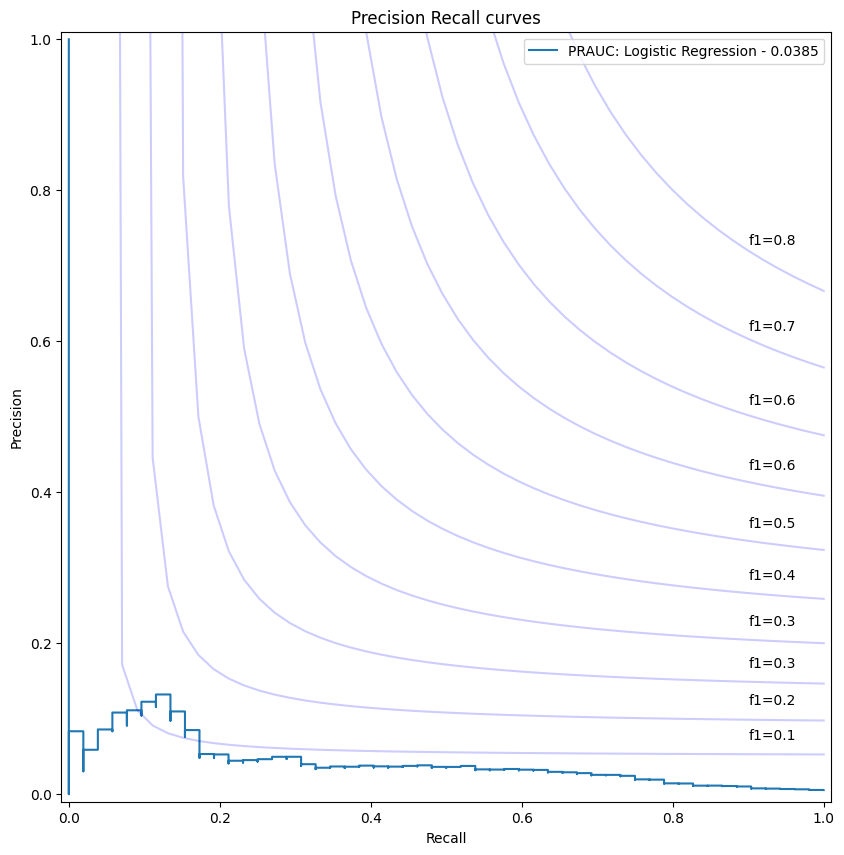

In [20]:
plot_precision_recall(
    df=df_test,
    model_probas={
        "Logistic Regression": probas_pred_lr
    }
)

<h4>TOP-K accuracy or Hit Ratio K</h4>

In [21]:
def calculate_topk(
    df: pd.DataFrame, y_proba: np.array, topk_bins: List[int]
) -> Dict[int, float]:
    """Compute top-k accuracy of the model using validation sample"""

    topk_vals = []
    
    df["y_proba"] = y_proba

    for K in topk_bins: 

        topk: List[bool] = []

        for _, df_pump in df.groupby("pump_hash"):
            df_pump: pd.DataFrame = df_pump.sort_values(by="y_proba", ascending=False) # sort tickers by logits 
            topk_contains_pump: bool = df_pump.iloc[:K]["is_pumped"].any() # see if any of the top k logits has label is_pumped == 1
            topk.append(topk_contains_pump) 

        topk_vals.append(
            sum(topk) / len(topk) # probability of having true label in top-k logits
        )
            
    return dict(zip(topk_bins, topk_vals))

In [22]:
topk_bins: List[int] = [1, 3, 5, 10, 20, 30]

topk: Dict[int, float] = calculate_topk(df=df_test, y_proba=probas_pred_lr, topk_bins=topk_bins)

df_topk = pd.DataFrame({
    "K": topk.keys(),
    "HR@K": topk.values()
})

df_topk

,K,HR@K
0,1,0.076923
1,3,0.211538
2,5,0.250000
3,10,0.365385
4,20,0.596154
5,30,0.730769


<h4>We would like to have a metric taking into account top-k performance for all Ks</h4>


$$\text{Avg} \hspace{0.25em} \frac{\partial{\text{TOP-K}}}{\partial{K}} \approx \frac{1}{|K|} \sum_{k \in K} \frac{\Delta \text{TOP-k}}{\Delta k} \hspace{1em} \text{where} \hspace{0.25em} K = \{1, 3, 5, 10, 20, 30\}$$

In [23]:
# We would like to maximize returns on increasing K

def calculate_mean_topk_derivative(
    df: pd.DataFrame, y_proba: np.array, topk_bins: List[int]
) -> float:
    """Calculates average mean increase in TOP-K as K increases"""
    topk: Dict[int, float] = calculate_topk(df=df, y_proba=y_proba, topk_bins=topk_bins)

    df_topk = pd.DataFrame({
        "K": topk.keys(),
        "HR@K": topk.values()
    })

    return np.mean(
        df_topk["HR@K"].diff() / df_topk["K"].diff()
    )

<h4>TOP-K AUC</h4>

In [24]:
# calculate Area-Under TOP-K curve

def calculate_topk_auc(
    df: pd.DataFrame, y_proba: np.array, topk_bins: Iterable[int]
) -> float:
    """Calculate TOP-K AUC for given logits and bins"""
    topk: Dict[int, float] = calculate_topk(df=df, y_proba=y_proba, topk_bins=topk_bins)
    topk_vals: np.ndarray[int] = np.array(list(topk.values()))
    topk_bins = topk_bins / topk_bins.max() # scale to [0, 1]

    return auc(x=topk_bins, y=topk_vals)

topk_bins = np.arange(1, 31)

calculate_topk_auc(df=df_test, y_proba=probas_pred_lr, topk_bins=topk_bins)

0.4737179487179486

<h4>TOP-K%</h4>

All cross-sections are of different sizes therefore it will be better to use TOP-K% instead of just K. This metric shows the probability of having a true label withing K% of the alternatives

In [25]:
def calculate_topk_percent(
    df: pd.DataFrame, probas_pred: np.array, topk_share_bins: np.array
) -> Dict[float, float]:
    """Calculates TOP-K% for a given model and ground truth stored in df"""

    dfc: pd.DataFrame = df.copy()
    dfc["probas_pred"] = probas_pred

    topk_vals: Dict[float, List[float]] = {K: [] for K in topk_share_bins}

    for _, df_pump in dfc.groupby("pump_hash"):
        df_pump: pd.DataFrame = df_pump.sort_values(by="probas_pred", ascending=False) # sort tickers by logits 
        # calculate percentages 
        df_pump = df_pump.reset_index(drop=True) # reset index based off which we will compute percentage
        df_pump["percentage"] = (df_pump.index + 1) / df_pump.shape[0]

        for K in topk_share_bins:
            # leave observations below K% of the cross-section
            df_pump_portfolio: pd.DataFrame = df_pump[df_pump["percentage"] <= K].copy()
            topk_contains_pump: bool = df_pump_portfolio["is_pumped"].any() # see if any of the top k% logits has label is_pumped == 1
            topk_vals[K].append(topk_contains_pump)

    return {K: np.mean(topk_vals[K]) for K in topk_share_bins}

In [26]:
calculate_topk_percent(
    df=df_test, probas_pred=probas_pred_lr, topk_share_bins=[0.1, 0.2, 0.3, 0.4, 0.5]
)

{0.1: 0.5576923076923077,
 0.2: 0.7307692307692307,
 0.3: 0.7884615384615384,
 0.4: 0.8461538461538461,
 0.5: 0.9038461538461539}

<h4>TOP-K% AUC</h4>

In [27]:
def calculate_topk_percent_auc(
    df: pd.DataFrame, probas_pred: np.array, topk_share_bins: np.array
) -> float:
    """Calculates Area under TOP-K% curve"""
    topk: Dict[float, float] = calculate_topk_percent(
        df=df, probas_pred=probas_pred, topk_share_bins=topk_share_bins
    )
    topk_vals: List[float] = list(topk.values())
    return auc(x=topk_share_bins, y=topk_vals)

In [28]:
X = np.arange(0.01, 1.01, 0.01)

calculate_topk_percent_auc(
    df=df_test, probas_pred=probas_pred_lr, topk_share_bins=X
)

0.8202884615384617

<h4>Random Forest Classifier</h4>

<p>We also need to create custom Fold generator that takes into account our cross-sectional style of data</p>

In [35]:
class KFoldCrosssection:

    def __init__(self, n_splits: int) -> Self:
        self.n_splits: int = n_splits

    def split(self, df: pd.DataFrame) -> Iterable[Union[pd.DataFrame, pd.DataFrame]]:
        """Split dataframe into K contiguous splits taking into account cross-sectional structure of the data"""
        bins: np.array = np.linspace(
            df["pump_id"].min(), df["pump_id"].max(), self.n_splits
        )

        for i in range(1, len(bins)):
            val_fold: pd.Series = (df["pump_id"] >= bins[i-1]) & (df["pump_id"] < bins[i]) # splits based on pump_ids
            train, val = df[~val_fold].copy(), df[val_fold].copy()

            yield train, val

In [36]:
fold = KFoldCrosssection(n_splits=6)

for train, val in fold.split(df_train):
    ...

In [37]:
from sklearn.ensemble import RandomForestClassifier
from optuna.trial import Trial
from functools import partial


import optuna


def objective_rf(
    trial: Trial, df_train: pd.DataFrame, reg_cols: List[str], target: str,
    fold: KFoldCrosssection
) -> Tuple[float, float]:
    """Optimize RandomForest hyperparameters to maximize top_k accuracy"""

    model = RandomForestClassifier(
        criterion="gini",
        # max_features="sqrt",
        class_weight="balanced",
        n_jobs=-1, # use all 24 cpu cores
        # max depth of grown trees, (it is typically better to have more of smaller trees so there is no overfit)
        max_depth=trial.suggest_int("max_depth", 2, 10),
        # number of trees grown in our ensemble
        n_estimators=trial.suggest_int("n_estimators", 100, 2000),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 15),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 2, 15),
        min_impurity_decrease=trial.suggest_float("min_impurity_decrease", 0, 0.01),
        max_samples=trial.suggest_float("max_samples", 0.5, 1), # use not all observations to avoid overfit
    )

    topk_percent_auc_scores: List[int] = []
    X: np.array = np.arange(0, 1.01, 0.01) # Percentage bins for TOP-K% AUC

    train: pd.DataFrame
    val: pd.DataFrame

    for train, val in fold.split(df_train):
        model.fit(X=train[reg_cols], y=train[target])
        # Predict probas for validation fold
        probas_pred: np.array = model.predict_proba(val[reg_cols])[:, 1] # for minority class

        topk_percent_auc: float = calculate_topk_percent_auc(df=val, probas_pred=probas_pred, topk_share_bins=X)
        topk_percent_auc_scores.append(topk_percent_auc) # optimize for top-30 accuracy

    return np.mean(topk_percent_auc_scores) # return average top-k auc

In [38]:
fold = KFoldCrosssection(n_splits=5)

In [ ]:
# run optuna study to maximize top_k over hyperparams
study_rf = optuna.create_study(
    direction="maximize"
)

study_rf.optimize(
    partial(objective_rf, df_train=df_train, reg_cols=reg_cols, target="is_pumped", fold=fold), 
    n_trials=100
)

<h4>Train tuned RandomForestClassifier</h4>

In [40]:
model = RandomForestClassifier(
    criterion="gini", class_weight="balanced",
    n_jobs=-1,
    **study_rf.best_params
)

model.fit(df_train[reg_cols], df_train["is_pumped"])

RandomForestClassifier(class_weight='balanced', max_depth=9,
                       max_samples=0.9124989059580688,
                       min_impurity_decrease=0.00504454069924964,
                       min_samples_leaf=3, min_samples_split=12,
                       n_estimators=755, n_jobs=-1)

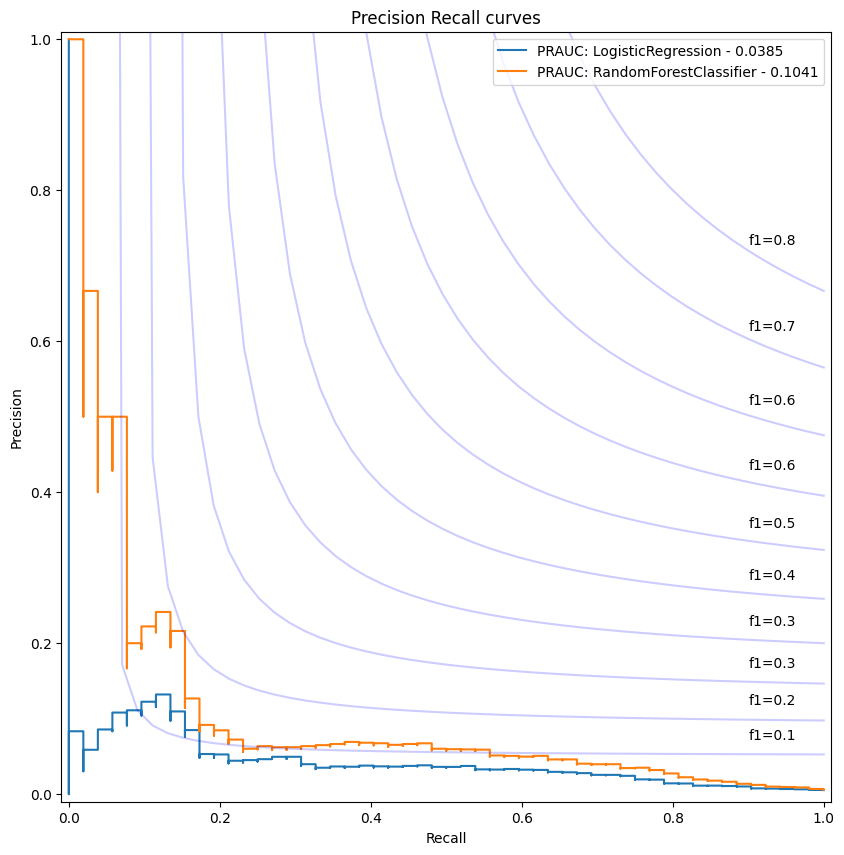

In [41]:
probas_pred_rf = model.predict_proba(df_test[reg_cols])[:, 1]

ax = plot_precision_recall(
    df=df_test, model_probas={
        "LogisticRegression": probas_pred_lr,
        "RandomForestClassifier": probas_pred_rf
    }
)

plt.show()

In [42]:
topk_bins = [1, 3, 5, 10, 20, 30]

calculate_topk(df=df_test, y_proba=probas_pred_rf, topk_bins=topk_bins)

{1: 0.1346153846153846,
 3: 0.21153846153846154,
 5: 0.2692307692307692,
 10: 0.5384615384615384,
 20: 0.75,
 30: 0.7884615384615384}

In [43]:
calculate_topk_auc(df=df_test, y_proba=probas_pred_rf, topk_bins=np.arange(1, 31))

0.5801282051282053

In [44]:
calculate_topk_percent(
    df=df_test, probas_pred=probas_pred_rf, topk_share_bins=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
)

{0.01: 0.1346153846153846,
 0.05: 0.5192307692307693,
 0.1: 0.6923076923076923,
 0.2: 0.8076923076923077,
 0.3: 0.8846153846153846,
 0.4: 0.8846153846153846,
 0.5: 0.9038461538461539}

In [45]:
calculate_topk_percent_auc(
    df=df_test, probas_pred=probas_pred_rf, topk_share_bins=X
)

0.876826923076923

<h4>Confusion matrix</h4>

<p>To make top-1 prediction from logits we need to set up a threshold which will have a trade-off between precision and recall</p>

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Set cutoff
threshold = 0.718
y_pred = (probas_pred_rf >= threshold).astype(int)

report = classification_report(y_true=df_test["is_pumped"], y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      9489
        True       0.15      0.15      0.15        52

    accuracy                           0.99      9541
   macro avg       0.57      0.57      0.57      9541
weighted avg       0.99      0.99      0.99      9541



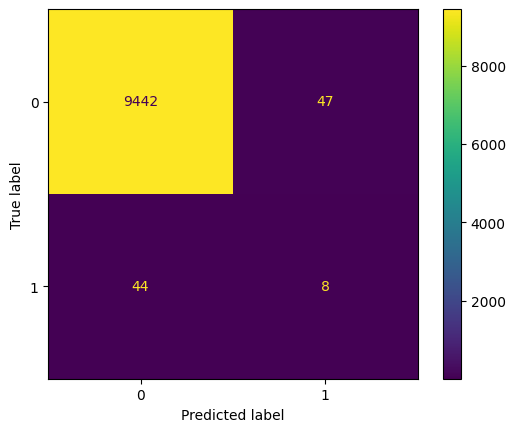

In [47]:
# plot confusion matrix given a threshold
cm = confusion_matrix(y_true=df_test["is_pumped"], y_pred=y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

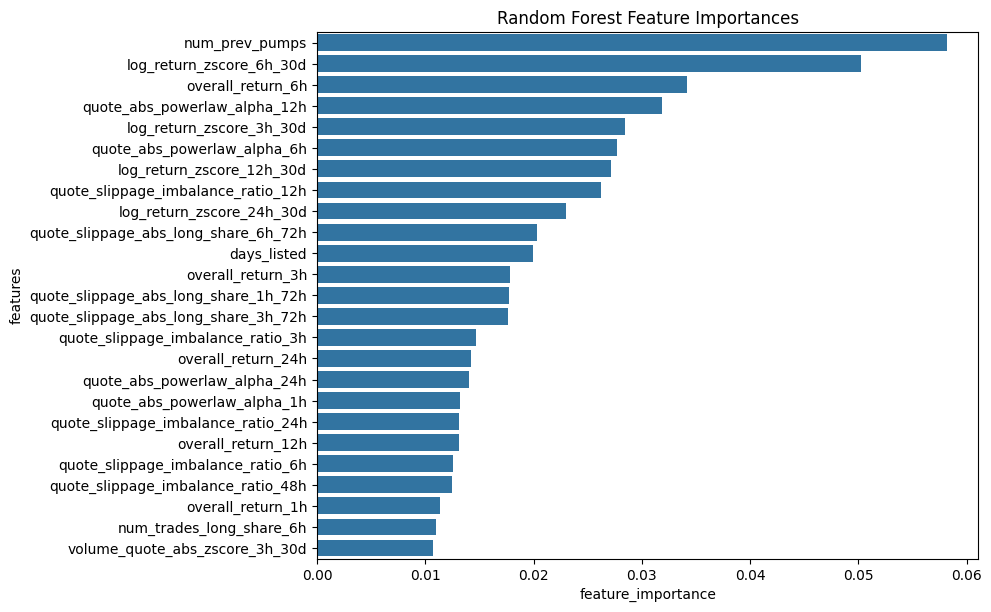

In [48]:
df_fi: pd.DataFrame = pd.DataFrame({
    "features": model.feature_names_in_,
    "feature_importance": model.feature_importances_
}).sort_values(by="feature_importance", ascending=False)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

sns.barplot(
    data=df_fi.iloc[:25], x="feature_importance", y="features", ax=ax,
)

plt.tight_layout()
plt.title("Random Forest Feature Importances")
plt.show()

<h4>Boosting models</h4>

<h4>XGBoostClassifier</h4>

In [53]:
import xgboost as xgb


def objective_xgboost(
    trial: Trial, df_train: pd.DataFrame, reg_cols: List[str], target: str,
    fold: KFoldCrosssection
) -> float:
    """Optimize XGBoostClassifier hyperparameters to maximize top_k accuracy"""

    xgb_params = {
        "objective": "binary:logistic",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 5), # prefer shallow trees
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 500),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "subsample": trial.suggest_float("subsample", 0.5, 1)
    }

    num_boost_round: int = trial.suggest_int("num_boosting_rounds", 10, 300)

    topk_percent_auc_scores: List[int] = []
    X: np.array = np.arange(0, 1.01, 0.01) # Percentage bins for TOP-K% AUC

    train: pd.DataFrame
    val: pd.DataFrame

    for train, val in fold.split(df_train):

        dtrain: xgb.DMatrix = xgb.DMatrix(train[reg_cols], label=train[target], enable_categorical=True)
        dval: xgb.DMatrix = xgb.DMatrix(val[reg_cols], label=val[target], enable_categorical=True)
        
        # Fit the model with early stopping, once eval metric doesn't improve for 10 round
        # boosting will stop
        model = xgb.train(
            xgb_params, dtrain=dtrain, num_boost_round=num_boost_round
        )
        
        # Predict probas for validation fold
        probas_pred: np.array = model.predict(dval) # for minority class

        topk_percent_auc: float = calculate_topk_percent_auc(df=val, probas_pred=probas_pred, topk_share_bins=X) # find top k scores
        topk_percent_auc_scores.append(topk_percent_auc) # optimize for top-30 accuracy


    return np.mean(topk_percent_auc_scores) # return average top_k accuracy across all folds

In [54]:
study_xgboost = optuna.create_study(
    direction="maximize"
)

study_xgboost.optimize(
    partial(objective_xgboost, df_train=df_train, reg_cols=reg_cols, target="is_pumped", fold=fold), 
    n_trials=10
)

[I 2024-06-18 16:13:26,833] A new study created in memory with name: no-name-248261d5-5f42-408b-b213-8d5dfe86dd12
[I 2024-06-18 16:13:36,037] Trial 0 finished with value: 0.7459877196777365 and parameters: {'learning_rate': 0.09430670194391214, 'max_depth': 2, 'scale_pos_weight': 381.1439115909521, 'colsample_bytree': 0.5983446294883983, 'subsample': 0.9666425738094075, 'num_boosting_rounds': 138}. Best is trial 0 with value: 0.7459877196777365.
[I 2024-06-18 16:13:44,888] Trial 1 finished with value: 0.7337715313592221 and parameters: {'learning_rate': 0.016176030091368993, 'max_depth': 4, 'scale_pos_weight': 408.3152106244483, 'colsample_bytree': 0.5124367566314505, 'subsample': 0.6916191552144177, 'num_boosting_rounds': 43}. Best is trial 0 with value: 0.7459877196777365.
[I 2024-06-18 16:13:54,473] Trial 2 finished with value: 0.7196274159333008 and parameters: {'learning_rate': 0.031527933935842065, 'max_depth': 5, 'scale_pos_weight': 140.2652762327952, 'colsample_bytree': 0.63095

In [55]:
# train tuned model
xgb_params = {
    "objective": "binary:logistic",
}

num_boost_round = study_xgboost.best_params["num_boosting_rounds"]

xgb_params.update(study_xgboost.best_params)
del xgb_params["num_boosting_rounds"]

In [56]:
dtrain: xgb.DMatrix = xgb.DMatrix(data=df_train[reg_cols], label=df_train["is_pumped"], enable_categorical=True)
dtest: xgb.DMatrix = xgb.DMatrix(data=df_test[reg_cols], label=df_test["is_pumped"], enable_categorical=True)

model = xgb.train(
    params=xgb_params, dtrain=dtrain, num_boost_round=num_boost_round
)

xgboost_y_proba: np.array = model.predict(dtest)

In [57]:
model.num_boosted_rounds()

156

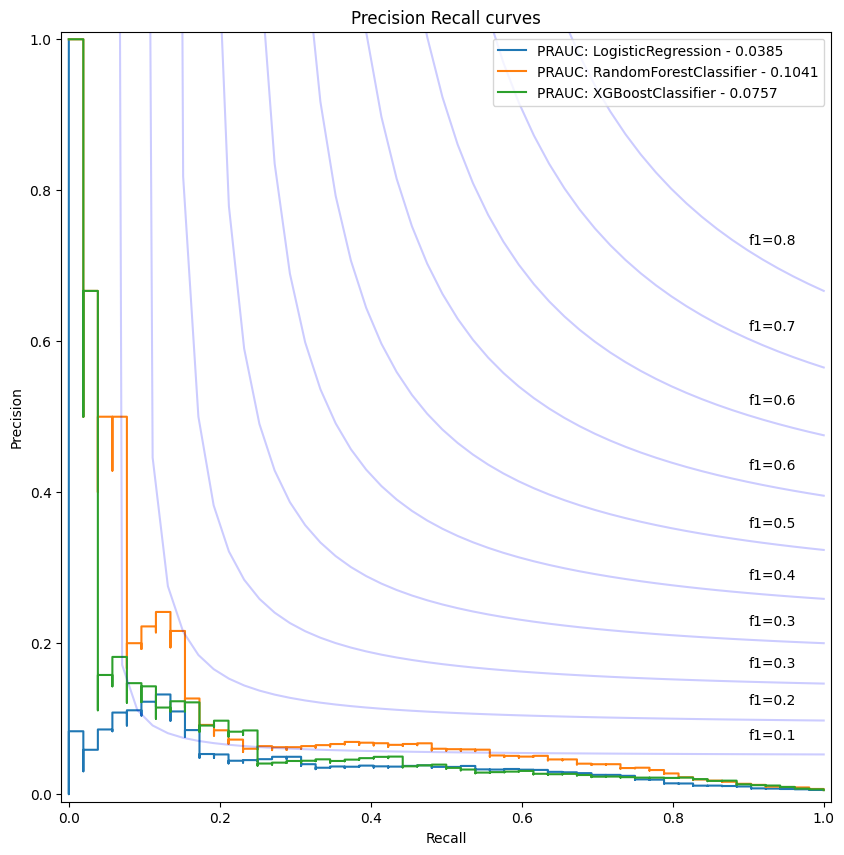

In [58]:
probas_pred_xgboost = model.predict(dtest)

ax = plot_precision_recall(
    df=df_test, model_probas={
        "LogisticRegression": probas_pred_lr,
        "RandomForestClassifier": probas_pred_rf,
        "XGBoostClassifier": probas_pred_xgboost
    }
)

plt.show()

In [59]:
calculate_topk(df=df_test, y_proba=probas_pred_xgboost, topk_bins=topk_bins)

{1: 0.11538461538461539,
 3: 0.25,
 5: 0.2692307692307692,
 10: 0.38461538461538464,
 20: 0.6346153846153846,
 30: 0.7115384615384616}

In [60]:
calculate_topk_auc(df=df_test, y_proba=probas_pred_xgboost, topk_bins=np.arange(1, 31))

0.4958333333333332

In [61]:
calculate_topk_percent_auc(df=df_test, probas_pred=probas_pred_xgboost, topk_share_bins=np.arange(0, 1.01, 0.01))

0.8582692307692308

<h4>CatboostClassifier</h4>

In [63]:
from catboost import CatBoostClassifier, Pool
import catboost as cb


def objective_catboost(
    trial: Trial, df_train: pd.DataFrame, reg_cols: List[str], target: str,
    fold: KFoldCrosssection
) -> float:

    cb_params = {
        "objective": "Logloss",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "class_weights": [1, trial.suggest_float("scale_pos_weight", 1, 500)],
    }

    num_boost_round: int = trial.suggest_int("num_boost_round", 10, 300)

    topk_percent_auc_scores: List[int] = []
    X: np.array = np.arange(0, 1.01, 0.01) # Percentage bins for TOP-K% AUC

    train: pd.DataFrame
    val: pd.DataFrame

    for train, val in fold.split(df_train):

        ptrain: Pool = Pool(data=train[reg_cols], label=train[target], cat_features=["num_prev_pumps"])
        pval: Pool = Pool(data=val[reg_cols], label=val[target], cat_features=["num_prev_pumps"])
        
        # Fit the model with early stopping
        model = CatBoostClassifier(
            **cb_params, task_type="GPU", devices="0", num_boost_round=num_boost_round, verbose=False
        )
        model.fit(ptrain)
        
        # Predict probas for validation fold
        probas_pred: np.array =  model.predict_proba(pval)[:, 1] # for minority class

        topk_percent_auc: float = calculate_topk_percent_auc(df=val, probas_pred=probas_pred, topk_share_bins=X) # find top k scores
        topk_percent_auc_scores.append(topk_percent_auc) # optimize for TOP-K AUC

    return np.mean(topk_percent_auc_scores)

In [64]:
study_catboost = optuna.create_study(
    direction="maximize"
)

study_catboost.optimize(
    partial(objective_catboost, df_train=df_train, reg_cols=reg_cols, target="is_pumped", fold=fold), 
    n_trials=10
)

[I 2024-06-18 16:17:10,012] A new study created in memory with name: no-name-aa18c680-d0eb-40d6-8296-3999747dc516
[I 2024-06-18 16:17:21,074] Trial 0 finished with value: 0.7090367325747312 and parameters: {'learning_rate': 0.014591028583268552, 'max_depth': 2, 'scale_pos_weight': 25.575238642286077, 'num_boost_round': 63}. Best is trial 0 with value: 0.7090367325747312.
[I 2024-06-18 16:18:06,471] Trial 1 finished with value: 0.7046971604126582 and parameters: {'learning_rate': 0.05384217588844207, 'max_depth': 4, 'scale_pos_weight': 194.96267466168882, 'num_boost_round': 232}. Best is trial 0 with value: 0.7090367325747312.
[I 2024-06-18 16:18:39,247] Trial 2 finished with value: 0.653293503402135 and parameters: {'learning_rate': 0.16274627563229185, 'max_depth': 4, 'scale_pos_weight': 287.8736462357573, 'num_boost_round': 173}. Best is trial 0 with value: 0.7090367325747312.
[I 2024-06-18 16:18:53,235] Trial 3 finished with value: 0.7669012050255968 and parameters: {'learning_rate'

In [65]:
# train tuned model
cb_params = {
    "objective": "Logloss",
}

num_boost_round = study_catboost.best_params["num_boost_round"]

cb_params.update(study_catboost.best_params)
del cb_params["num_boost_round"]

In [66]:
ptrain: Pool = Pool(data=df_train[reg_cols], label=df_train["is_pumped"], cat_features=["num_prev_pumps"])
ptest: Pool = Pool(data=df_test[reg_cols], label=df_test["is_pumped"], cat_features=["num_prev_pumps"])

In [132]:
model = CatBoostClassifier(
    **cb_params, task_type="GPU", devices="0", num_boost_round=num_boost_round, verbose=False
)

model.fit(ptrain)

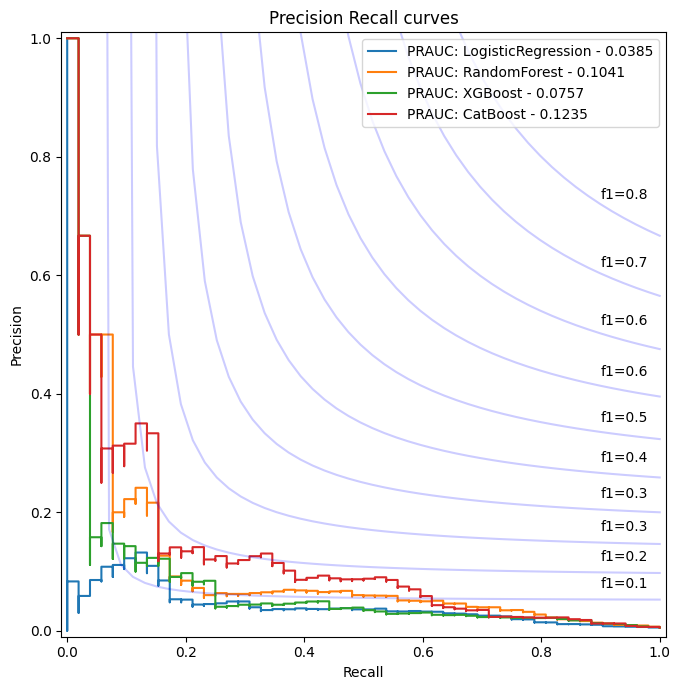

In [130]:
probas_pred_catboost = model.predict_proba(ptest)[:, 1]

ax = plot_precision_recall(
    df=df_test, model_probas={
        "LogisticRegression": probas_pred_lr,
        "RandomForest": probas_pred_rf,
        "XGBoost": probas_pred_xgboost,
        "CatBoost": probas_pred_catboost
    },
    figsize=(7, 7)
)

plt.tight_layout()
plt.savefig("precision_recall_test.png", transparent=True)
plt.show()

In [73]:
calculate_topk_percent_auc(
    df=df_test, probas_pred=probas_pred_catboost, topk_share_bins=np.arange(0, 1.01, 0.01)
)

0.8728846153846154

In [76]:
calculate_topk(df=df_test, y_proba=probas_pred_catboost, topk_bins=[1, 3, 5, 10, 20, 30])

{1: 0.19230769230769232,
 3: 0.3269230769230769,
 5: 0.4230769230769231,
 10: 0.5769230769230769,
 20: 0.7115384615384616,
 30: 0.7884615384615384}

In [113]:
model_probas = {
    "LogisticRegression": probas_pred_lr,
    "RandomForest": probas_pred_rf,
    "XGBoost": probas_pred_xgboost,
    "CatBoost": probas_pred_catboost
}


res = []

for name, proba in model_probas.items():
    topk_vals = calculate_topk(df=df_test, y_proba=proba, topk_bins=[1, 3, 5, 10, 20, 30]).values()
    res.append(list(topk_vals))


df_topk = pd.DataFrame(
    data=res
).T

df_topk.columns = model_probas.keys()
df_topk.index = [f"TOP-{i}" for i in [1, 3, 5, 10, 20, 30]]

df_topk

,LogisticRegression,RandomForest,XGBoost,CatBoost
TOP-1,0.076923,0.134615,0.115385,0.192308
TOP-3,0.211538,0.211538,0.250000,0.326923
TOP-5,0.250000,0.269231,0.269231,0.423077
TOP-10,0.365385,0.538462,0.384615,0.576923
TOP-20,0.596154,0.750000,0.634615,0.711538
TOP-30,0.730769,0.788462,0.711538,0.788462


In [114]:
res = []

for name, proba in tqdm(model_probas.items()):
    topk_vals = calculate_topk_percent(df=df_test, probas_pred=proba, topk_share_bins=np.arange(0, 1.01, 0.01)).values()
    res.append(list(topk_vals))

100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


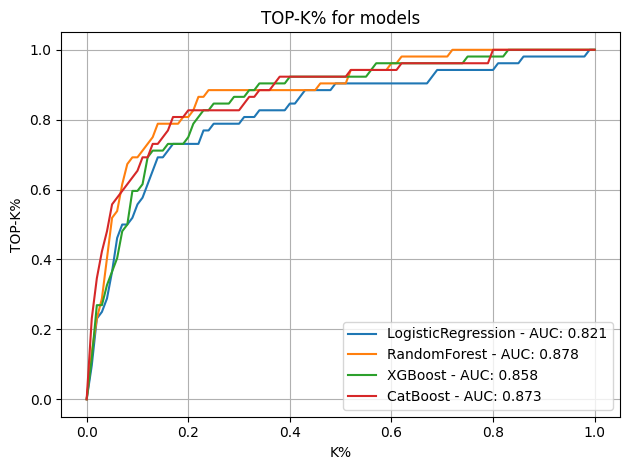

In [131]:
df_topkp = pd.DataFrame(data=res).T
df_topkp.columns = model_probas.keys()

X = np.arange(0, 1.01, 0.01)

for col in df_topkp.columns:
    auc_score = auc(x=X, y=df_topkp[col])
    plt.plot(X, df_topkp[col], label=f"{col} - AUC: {auc_score:.3f}")

plt.title("TOP-K% for models")
plt.ylabel("TOP-K%")
plt.xlabel("K%")

plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig("topk_percent_res.png", transparent=True)

plt.show()

<h4>Feature importances</h4>

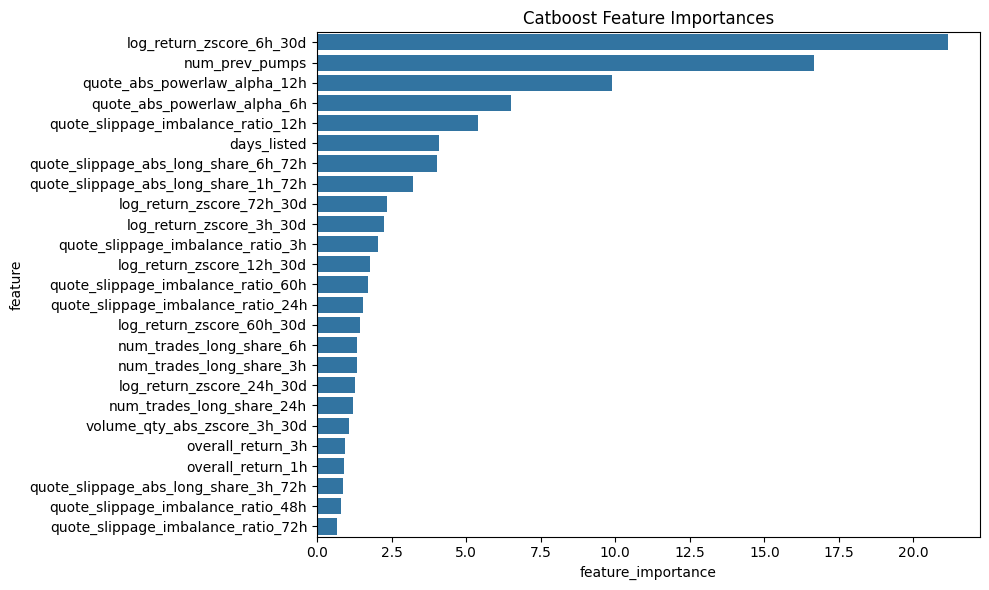

In [153]:
df_fi_cb = pd.DataFrame({
    "feature": model.feature_names_,
    "feature_importance": model.feature_importances_
})

df_fi_cb = df_fi_cb.sort_values(by="feature_importance", ascending=False)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

sns.barplot(
    data=df_fi_cb.iloc[:25], x="feature_importance", y="feature", ax=ax,
)

plt.title("Catboost Feature Importances")
plt.tight_layout()

plt.savefig("catboost_feature_importances.png", transparent=True)
plt.show()

<h4>Calculate profitability of the strategy</h4>